# Inference

Testing the inference API

In [39]:
from glob import glob
import random
import rasterio as rio
import numpy as np
import requests
import matplotlib.pyplot as plt
import io
import json
from matplotlib.colors import ListedColormap
from PIL import Image

In [34]:
images = glob('data/*_TOA.tif')

In [59]:
sample = random.choice(images)
sample

'data/20221118_173224_SN20_22S_629564_7219654_TOA.tif'

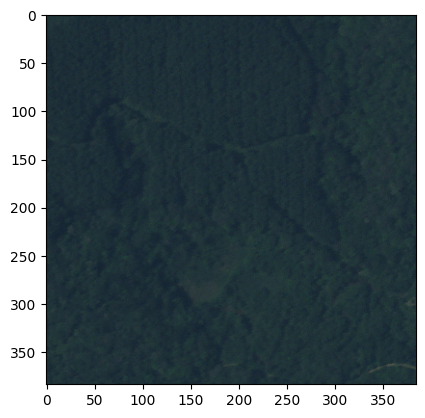

In [60]:
ds = rio.open(sample)
rgb = (ds.read([1, 2, 3]) / 4000).clip(0, 1)
plt.imshow(rgb.transpose(1, 2, 0))
plt.show()

In [61]:
url = 'http://localhost:8001/classification/classification.onnx'

res = requests.post(url, files={'image': open(sample, 'rb')})
if res.status_code != 200:
	print(res.json())

outputs = res.json()
outputs

[[0.028890401124954224,
  0.5537939667701721,
  0.1425037682056427,
  0.04348146915435791,
  0.043166160583496094,
  0.29193228483200073]]

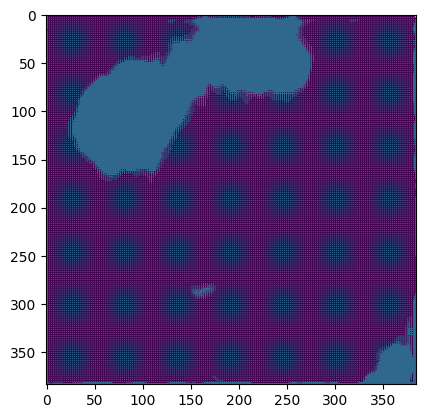

In [62]:
url = 'http://localhost:8001/segmentation/segmentation.onnx'

res = requests.post(url, files={'image': open(sample, 'rb')})
if res.status_code != 200:
	print(res.json())

image_bytes = io.BytesIO(res.content)
img = Image.open(image_bytes)
array = np.array(img)
plt.imshow(array)

In [63]:
with open('data/spai.json', 'r') as f:
    data = json.load(f)

data

{'labels': [{'name': 'industrial', 'color': '#276926'},
  {'name': 'parking lot', 'color': '#ff0000'},
  {'name': 'solar panel', 'color': '#224b81'},
  {'name': 'wind turbine', 'color': '#bf661d'},
  {'name': 'train', 'color': '#1dbf96'},
  {'name': 'construction equipment', 'color': '#388999'},
  {'name': 'airplane', 'color': '#00d5ff'},
  {'name': 'boat/ship', 'color': '#c800ff'},
  {'name': 'truck', 'color': '#9f2371'},
  {'name': 'car', 'color': '#ff0000'},
  {'name': 'bare soil', 'color': '#a38e05'},
  {'name': 'forest', 'color': '#8cff00'},
  {'name': 'agricultural', 'color': '#fbff00'},
  {'name': 'urban', 'color': '#ff00f7'},
  {'name': 'water', 'color': '#001eff'}]}

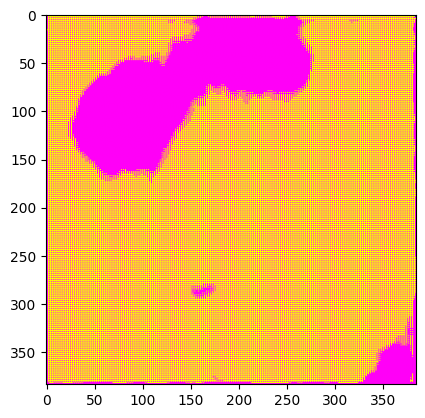

In [64]:
colors = ['#000000'] + [label['color'] for label in data['labels']]
cmap = ListedColormap(colors)

plt.imshow(array, cmap=cmap, vmin=0, vmax=len(colors))
plt.show()